<div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

# IOD Castone Project - Customer Experience (CX)

What is customer experience (CX), why is it important for business, and how can you improve it for your customers?

## Introduction

In [ ]:
IOD Capstone Project Notebook 1 with 7 emotion classification with Epochs 10 with predicted Emotion as Angry

## Import libraries

In [2]:
# Import libraries
import os
import cv2
import pandas as pd

In [3]:
# insert code here
import numpy as np
import keras
import tensorflow as tf
import tensorboard
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2
from sklearn.metrics import classification_report, confusion_matrix
from skimage.transform import resize


# import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D,MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping

# import tensorflow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import datasets, layers, models


## Define variables


In [ ]:
#num_classses = 5 : This variable defines the number of classes or the emotions that we will be dealing with in training our model.
#img_rows,img_cols=48,48 : These variables define the size of the image array that we will be feeding to our neural network.
#batch_size=32: This variable defines the batch size.The batch size is a number of samples 
                #processed before the model is updated. The size of a batch must be more than or equal to one and less than
                # or equal to the number of samples in the training dataset.
#The number of epochs is the number of complete passes hrough the training dataset. 

In [3]:
num_classes=5
img_rows,img_cols=48,48
batch_size=64

## Load data
Using the fer2013 dataset which is an open source dataset hosted on kaggle
The dataset contains totally 7 classes namely Angry,Disgust,Fear,Happy,Sad,Surprise and Neutral.The training set consists of a total of 28,709 examples.

In [4]:
data = pd.read_csv('fer2013.csv') 

In [5]:
data.shape

(35887, 3)

In [6]:
data.head(5)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [7]:
data.tail(5)

,emotion,pixels,Usage
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,Test
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,Test
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,Test
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,Test
35886,2,19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...,Test


In [16]:
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = data['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Angry,4953
1,Digust,547
2,Fear,5121
3,Happy,8989
4,Sad,6077
5,Surprise,4002
6,Neutral,6198


C:\Users\Reji\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


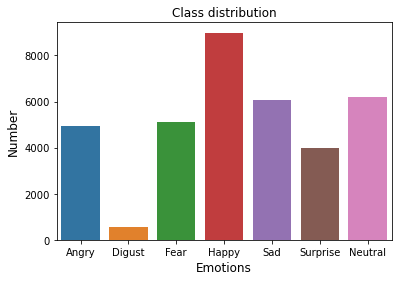

In [9]:
plt.figure(figsize=(6,4))
sns.barplot(emotion_counts.emotion, emotion_counts.number)
plt.title('Class distribution')
plt.ylabel('Number', fontsize=12)
plt.xlabel('Emotions', fontsize=12)
plt.show()

<ipython-input-10-483c62a7888b>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([image.astype(np.uint8), emotion])
<ipython-input-10-483c62a7888b>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([image.astype(np.uint8), emotion])
<ipython-input-10-483c62a7888b>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the nd

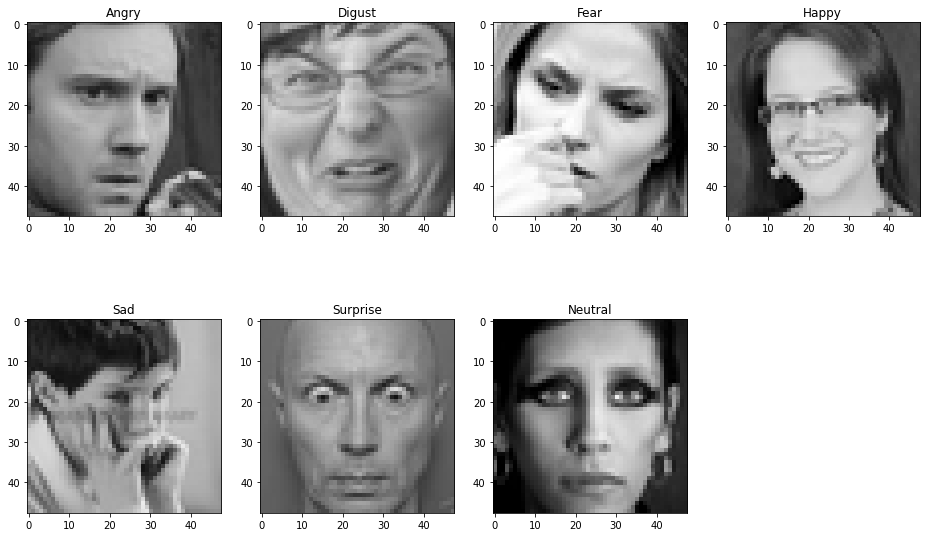

In [10]:
def row2image(row):
    pixels, emotion = row['pixels'], emotion_map[row['emotion']]
    img = np.array(pixels.split())
    img = img.reshape(48,48)
    image = np.zeros((48,48,3))
    image[:,:,0] = img
    image[:,:,1] = img
    image[:,:,2] = img
    return np.array([image.astype(np.uint8), emotion])

plt.figure(0, figsize=(16,10))
for i in range(1,8):
    face = data[data['emotion'] == i-1].iloc[0]
    img = row2image(face)
    plt.subplot(2,4,i)
    plt.imshow(img[0])
    plt.title(img[1])

plt.show()  

In [9]:
#split data into training, validation and test set
data_train = data[data['Usage']=='Training'].copy()
data_test  = data[data['Usage']=='Test'].copy()
print("train shape: {}, \ntest shape: {}".format(data_train.shape, data_test.shape))

train shape: (28709, 3), 
test shape: (7178, 3)


In [10]:
#initilize parameters
num_classes = 7 
width, height = 48, 48
num_epochs = 10
batch_size = 64
num_features = 64

In [11]:
def CRNO(df, dataName):
    df['pixels'] = df['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
    data_X = np.array(df['pixels'].tolist(), dtype='float32').reshape(-1,width, height,1)/255.0   
    data_Y = to_categorical(df['emotion'], num_classes)  
    print(dataName, "_X shape: {}, ", dataName, "_Y shape: {}".format(data_X.shape, data_Y.shape))
    return data_X, data_Y

    
train_X, train_Y = CRNO(data_train, "train") #training data
test_X, test_Y   = CRNO(data_test, "test") #test data

train _X shape: {},  train _Y shape: (28709, 48, 48, 1)
test _X shape: {},  test _Y shape: (7178, 48, 48, 1)


In [12]:
model = Sequential()

#module 1
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), input_shape=(width, height, 1), data_format='channels_last'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#module 2
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#module 3
model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#flatten
model.add(Flatten())

#dense 1
model.add(Dense(2*2*2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#dense 2
model.add(Dense(2*2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#dense 3
model.add(Dense(2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#output layer
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), 
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 256)       2560      
_________________________________________________________________
batch_normalization (BatchNo (None, 46, 46, 256)       1024      
_________________________________________________________________
activation (Activation)      (None, 46, 46, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 256)       590080    
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 46, 256)       1024      
_________________________________________________________________
activation_1 (Activation)    (None, 46, 46, 256)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 256)      

C:\Users\Reji\anaconda3\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [15]:
# data generator
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)


es = EarlyStopping(monitor='val_loss', patience = 10, mode = 'min', restore_best_weights=True)

#history = model.fit_generator(data_generator.flow(train_X, train_Y, batch_size),
#                                steps_per_epoch=len(train_X) / batch_size,
#                                epochs=num_epochs,
#                                verbose=2, 
#                                callbacks = [es],
#                                test_data=(test_X, test_Y))
hist = model.fit(train_X,train_Y,
               batch_size == 64, 
               epochs = 10, 
               validation_split = 0.2)

Epoch 1/10
22967/22967 [==============================] - 4739s 206ms/step - loss: 1.8188 - accuracy: 0.2511 - val_loss: 22672.8828 - val_accuracy: 0.1512
Epoch 2/10
22967/22967 [==============================] - 5117s 223ms/step - loss: 1.8111 - accuracy: 0.2512 - val_loss: 22148.2012 - val_accuracy: 0.1510
Epoch 3/10
22967/22967 [==============================] - 5995s 261ms/step - loss: 1.8111 - accuracy: 0.2512 - val_loss: 22613.8340 - val_accuracy: 0.1505
Epoch 4/10
22967/22967 [==============================] - 6234s 271ms/step - loss: 1.8111 - accuracy: 0.2512 - val_loss: 22177.7676 - val_accuracy: 0.1550
Epoch 5/10
22967/22967 [==============================] - 7745s 337ms/step - loss: 1.8111 - accuracy: 0.2512 - val_loss: 22862.2598 - val_accuracy: 0.1499
Epoch 6/10
22967/22967 [==============================] - 6529s 284ms/step - loss: 1.8112 - accuracy: 0.2512 - val_loss: 21912.5508 - val_accuracy: 0.1506
Epoch 7/10
22967/22967 [==============================] - 5731s 250ms/

In [17]:
model.evaluate(test_X, test_Y)[1]

225/225 [==============================] - 516s 2s/step - loss: 23815.6973 - accuracy: 0.1477


0.14767344295978546

<function matplotlib.pyplot.show(close=None, block=None)>

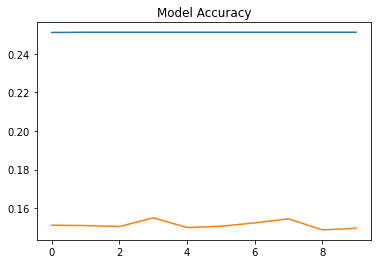

In [21]:
#visualize the model accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title ('Model Accuracy')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

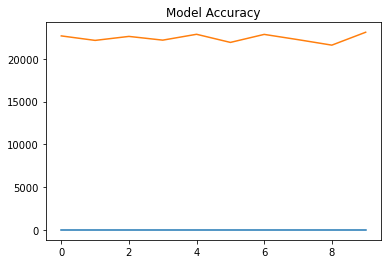

In [22]:
#visualize the loss accuracy
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title ('Model Accuracy')
plt.show

In [78]:
#![title](methil.jpg)

In [79]:
#from IPython.display import Image
#Image(filename="methil.jpg", width=48, height=48)
#color_mode='grayscale')

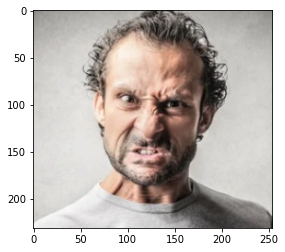

In [18]:
new_image = plt.imread('angryman.jpg')
img =plt.imshow(new_image)


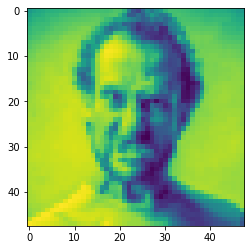

In [19]:
#resize Image
from skimage.transform import resize
resized_image = resize(new_image,(48,48,1))
img = plt.imshow(resized_image)

## Create predictions

In [23]:
# Model Prediction
predictions = model.predict(np.array([resized_image]))
predictions
                                    

array([[0.14495164, 0.14358902, 0.14080727, 0.14201152, 0.14254849,
        0.14360279, 0.14248931]], dtype=float32)

In [25]:
#sort the predictions from least to greatest
list_index = [0,1,2,3,4,5,6]
x = predictions

for i in range(7):
    for j in range(7):
        if x[0][list_index[i]] >x[0][list_index[j]]:
            temp = list_index[i]
            list_index[i] = list_index[j]
            list_index[j] = temp

#show the sorted lables in order
print(list_index)

[0, 5, 1, 4, 6, 3, 2]


In [26]:
#print the 7 predictions
for i in range(7):
    print(emotion_map[list_index[i]], ':', round(predictions[0][list_index[i]] * 100,2), '%')

Angry : 14.5 %
Surprise : 14.36 %
Digust : 14.36 %
Sad : 14.25 %
Neutral : 14.25 %
Happy : 14.2 %
Fear : 14.08 %


## Evaluate the model

![](angryman.jpg)

In [ ]:
14.5% shows as anagryman

## Visualisation 

In [ ]:
The goal of this exercise was to analyse the facial expressions of customers and predict the customer experience
using by the features like happy, sad, surprise etc features.

The above image comes as a angry and agreeable to the visual analysis of the image.



---



---



> > > > > > > > > © 2021 Institute of Data


---



---



